In [1]:
import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import contractions
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from gensim.models import Word2Vec
from gensim.models.word2vec import FAST_VERSION
from sklearn.manifold import TSNE
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.models import AuthorTopicModel
from gensim.test.utils import datapath, temporary_file
from collections import defaultdict

import time # to know how long training took
import multiprocessing # to speed things up by parallelizing
nlp = spacy.load('en_core_web_sm')

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

## 1. Data and Preprocessing

The dataset used for this project consists of 80.000 tweets containing the hashtag **#BlackLivesMatter** that I have scraped using the following commented code. 
40.000 tweets have been written from users in District of Columbia; 40.000 are from North Dakota. I chose these states because DC has always been Democratic, while North Dakota has always been Republican.
The aim is to compare democrats (people from DC) and republicans's (people from ND) approach and reaction to #BlackLivesMatter.

In [2]:
#Democratic state
DC = pd.read_csv("District_of_Columbia.csv").drop("permalink", axis = 1) #DC radius 4k
DC['State'] = 'DC'

#Republican state
ND = pd.read_csv("North_Dakota.csv").drop("permalink", axis = 1) #North Dakota
ND['State'] = 'ND'

df = pd.concat([DC,ND]).reset_index(drop = True)
len(df)

80000

In [3]:
df.State.value_counts()

ND    40000
DC    40000
Name: State, dtype: int64

In [4]:
#Check null values
df['text'].isna().sum() == 0

# Drop duplicated tweets
df = df.drop_duplicates(subset = ['text'])

In [5]:
df.State.value_counts()

DC    39910
ND    36835
Name: State, dtype: int64

In [6]:
df.groupby(['State'])['date'].agg([min,max])

,min,max
State,,
DC,2020-05-30,2020-05-30
ND,2021-03-06,2021-03-23


Apparenty, the scraping procedure did not manage to find tweets from North Dakota containing the hashtag #BlackLivesMatter dated before March 6 2021.
It is already interesting to notice how people in the democratic country of DC tweeted much more than people from North Dakota about the selected topic.

### Data exploration: some statistics

I notices that in the dataset of tweets there is a user named *OldMainBell* which only writes "Ding ding".
Therefore, I decided to delete his tweets because they are irrelevant and only create noise.

In [7]:
df[df['username'] == 'OldMainBell'].head(2)

,id,username,text,date,State
40060,1374496184950136836,OldMainBell,ding* ding? ding^ DING. ding ding... ding #Pen...,2021-03-23,ND
40135,1374481086646951944,OldMainBell,DING^ Ding &amp; ding &amp; ding ding ding... ...,2021-03-23,ND


In [8]:
idx_drop = df[df['username'] == 'OldMainBell'].index
df.drop(labels = idx_drop, axis=0,inplace= True)

In [9]:
df.reset_index(drop = True, inplace = True)

In [10]:
print("The dataframe contains: \n\n{} tweets for District of Columbia;\
    \n{} tweets for the Texas".format(len(df[df['State'] == 'DC']),
                                         len(df[df['State'] == 'ND']) ))

The dataframe contains: 

39910 tweets for District of Columbia;    
36432 tweets for the Texas


In [11]:
# Length of tweets
states = ['DC','ND']

for l in states:
    length = [len(tweet['text'].split()) for idx, tweet in df[df['State'] == l].iterrows()]
    print("BEFORE PRE PROCESSING: \nAverage length of tweets from {}: {} \n \
    Maximum length: {}; Minimum length: {}".format(l, round(np.mean(length), 2),
                                                        np.max(length), np.min(length)))

BEFORE PRE PROCESSING: 
Average length of tweets from DC: 23.79 
     Maximum length: 63; Minimum length: 2
BEFORE PRE PROCESSING: 
Average length of tweets from ND: 25.36 
     Maximum length: 70; Minimum length: 2


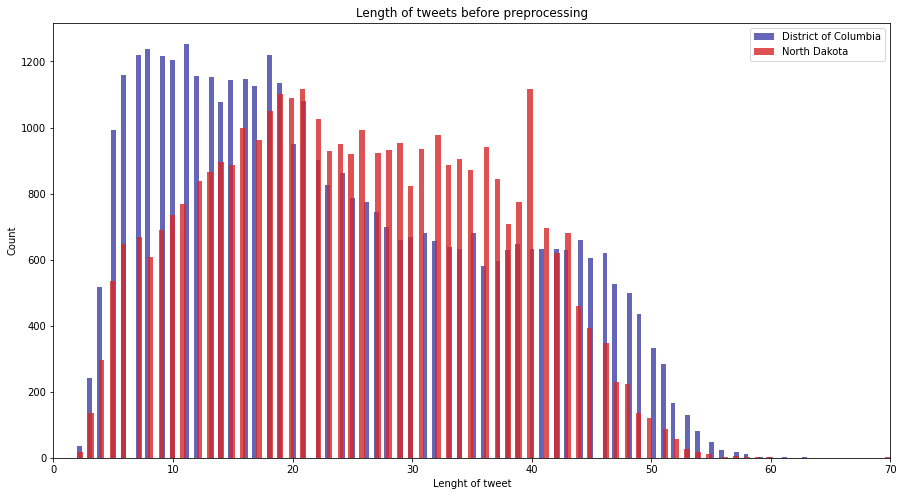

In [12]:
df['length_before'] = df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize = (15,8))
plt.title("Length of tweets before preprocessing")
bins = 150
plt.hist(df[df['State'] == 'DC']['length_before'], alpha = 0.6, bins=bins, label='District of Columbia', color = 'darkblue')
plt.hist(df[df['State'] == 'ND']['length_before'], alpha = 0.8, bins=bins, label='North Dakota', color = 'tab:red') 
plt.xlabel('Lenght of tweet')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.xlim(0,70)
plt.show()

In [13]:
df['length_tweet_before'] = df['text'].apply(lambda x: len(x))

print("BEFORE PRE PROCESSING: ")
for state in ['DC','ND']:
    print("\nAverage number of characters per tweet {}: {} \
    \n Maximum length: {}; Minimum length: {}".format(state, round(np.mean(df[df['State'] == state]['length_tweet_before']), 2),
                                                                np.max(df[df['State'] == state]['length_tweet_before']), 
                                                                np.min(df[df['State'] == state]['length_tweet_before'])))

BEFORE PRE PROCESSING: 

Average number of characters per tweet DC: 167.13     
 Maximum length: 339; Minimum length: 22

Average number of characters per tweet ND: 202.37     
 Maximum length: 400; Minimum length: 22


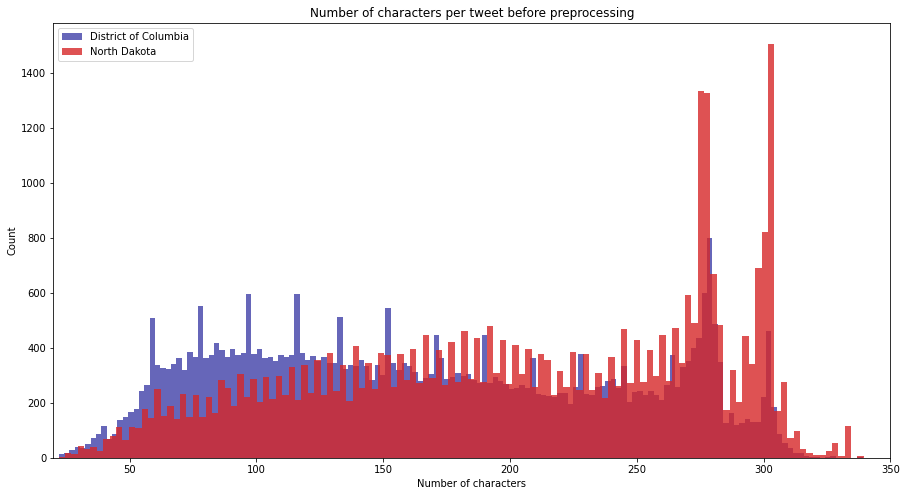

In [14]:
df['length_tweet_before'] = df['text'].apply(lambda x: len(x))

plt.figure(figsize = (15,8))
plt.title("Number of characters per tweet before preprocessing")
bins = 150
plt.hist(df[df['State'] == 'DC']['length_tweet_before'], alpha = 0.6, bins=bins, label='District of Columbia', color = 'darkblue')
plt.hist(df[df['State'] == 'ND']['length_tweet_before'], alpha = 0.8, bins=bins, label='North Dakota', color = 'tab:red') 
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.legend(loc ='upper left')
plt.xlim(20,350)
plt.show()

In [15]:
sum_bf_DC = df[df['State']=='DC']['text'].str.split().apply(lambda x : sum([len(i) for i in x]))
sum_bf_ND = df[df['State']=='ND']['text'].str.split().apply(lambda x : sum([len(i) for i in x]))

print('Average word length of tweets before preprocessing: \
        \n {} for District of Columbia; \n {} for North Dakota'.format(round(np.mean(sum_bf_DC), 2),
                                                                       round(np.mean(sum_bf_ND),2)))

Average word length of tweets before preprocessing:         
 143.36 for District of Columbia; 
 176.73 for North Dakota


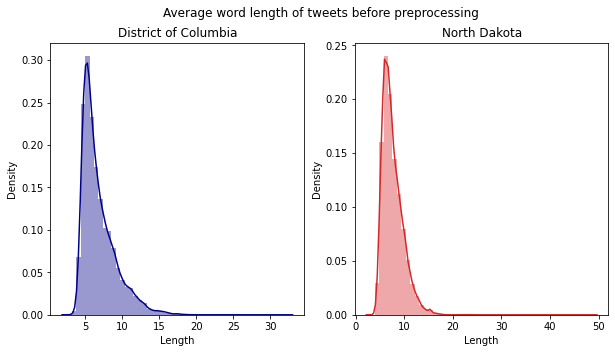

In [16]:
word_len_DC = df[df['State']=='DC']['text'].str.split().apply(lambda x : [len(i) for i in x])
word_len_ND = df[df['State']=='ND']['text'].str.split().apply(lambda x : [len(i) for i in x])

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(word_len_DC.map(lambda x: np.mean(x)), ax = ax1, color='darkblue')
ax1.set_title('District of Columbia')
ax1.set_xlabel('Length')
ax1.set_ylabel('Density')

sns.distplot(word_len_ND.map(lambda x: np.mean(x)),ax=ax2, color = 'tab:red')
ax2.set_title('North Dakota')
ax2.set_xlabel('Length')
ax2.set_ylabel('Density')

plt.suptitle('Average word length of tweets before preprocessing')
plt.show()

### Preprocessing

The following functions have been used to clean the dataset from the noise.
<br>
In detail, the steps I followed are:
1. Storing hashtags in a separate column of the DataFrame: I am not particularly interested in analyzing them for this project;
2. Removal of URL, user tags, hashtags, symbols, emoticons and numbers since they represent unuseful information for this task;
3. Fixing of the contractions (don't >> do not), so that to provide uniformity within the tweets;
4. Removal of stopwords so that to keep only meaningful tokens;
5. Lemmatization since I am more interested in the core meaning of words, rather in their morphology.
6. Removal of words which have length smaller or equal to 3, simply because the majority part of words with these lengths are not particularly significant.

In [17]:
sw = set(stopwords.words('english'))  
common_hashtags = ['#', '#blacklivesmatter', 'black_lives_matter', '#blm']
common_words = ['blacklivesmatter', 'blm']

def retrieve_hashtags(tweet):
    return [x.lower() for x in re.findall('#[A-Za-z0-9_-]*',tweet) if x.lower() not in common_hashtags]

#Tokenization and lemmatization
def lemmtoken(text):
    lemmas = [t.lemma_ for t in nlp(text) 
              if (t.pos_ in {'NOUN', 'VERB', 'ADJ'}) &
             (t.ent_type_ != 'DATE') &
             (t.lemma_ not in common_words)] # Remove entities representing dates
    return ' '.join(lemmas)

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\U0001F916"                   
        u"\u200d"
        u"\u2640-\u2642"
                           
        "]+", flags=re.UNICODE)

def remove_emoticons(text):
    return re.sub(emoji_pattern, '', text)


def preprocessing(df):
    #Store hashtags in a new column
    df['hashtags'] = df['text'].apply(lambda x: retrieve_hashtags(x))
    
    #Remove URLs
    df['normalized'] = df['text'].apply(lambda x: re.sub(r"http\S+", '', x))

    # Remove tags
    df['normalized'] = df['normalized'].apply(lambda x: re.sub('@[A-Za-z0-9\._]+','', x))

    #Remove hashtags 
    df['normalized'] = df['normalized'].apply(lambda x: re.sub('#[A-Za-z0-9_-]*','', x))

    #Remove contractions
    df['normalized'] = df['normalized'].apply(lambda x: contractions.fix(x.lower()))
    
    #Remove symbols and numbers 
    df['normalized'] = df['normalized'].apply(lambda x: re.sub("[^a-zA-Z ]", '', x))

    #Remove stopwords  
    df['normalized'] = df['normalized'].apply(lambda x: ' '.join([w for w in x.split() 
                                                                 if w not in sw]))
    #Remove emoticons
    df['normalized'] = df['normalized'].apply(lambda x: remove_emoticons(x))
    
    #Lemmatize and tokenize
    df['normalized'] = df['normalized'].apply(lemmtoken)
    
    #Remove words whose len is smaller than or equal to 3 
    df['normalized'] = df['normalized'].apply(lambda x: re.sub(r'\b\w{1,3}\b', '', x))
    
    return df

In [18]:
# PREPROCESSING THE WHOLE DATAFRAME

'''
Preprocessing takes some time to run!

'''

df = preprocessing(df)

Let's have a quick look at the pre-processed dataframe:

In [19]:
df.loc[0,'text']

"Yes, obviously all lives matter. That's kind of the point. Trouble is, people keep acting like not all lives matter. That's why people have to keep reminding you that #BlackLivesMatter too."

In [20]:
df.loc[0,'normalized']

'live point trouble people keep  life matter people keep remind'

### Statistics after pre-processing

In [21]:
states = ['DC','ND']
print("AFTER PRE-PROCESSING")
for l in states:
    length = [len(tweet['normalized'].split()) for idx, tweet in df[df['State'] == l].iterrows()]
    print("\nAverage length of tweets from {}: {} \n Maximum length: {}; Minimum length: {} \n\n ".format(l, round(np.mean(length), 2),
                                                                                  np.max(length), np.min(length)))

AFTER PRE-PROCESSING

Average length of tweets from DC: 7.59 
 Maximum length: 39; Minimum length: 0 

 

Average length of tweets from ND: 8.1 
 Maximum length: 28; Minimum length: 0 

 


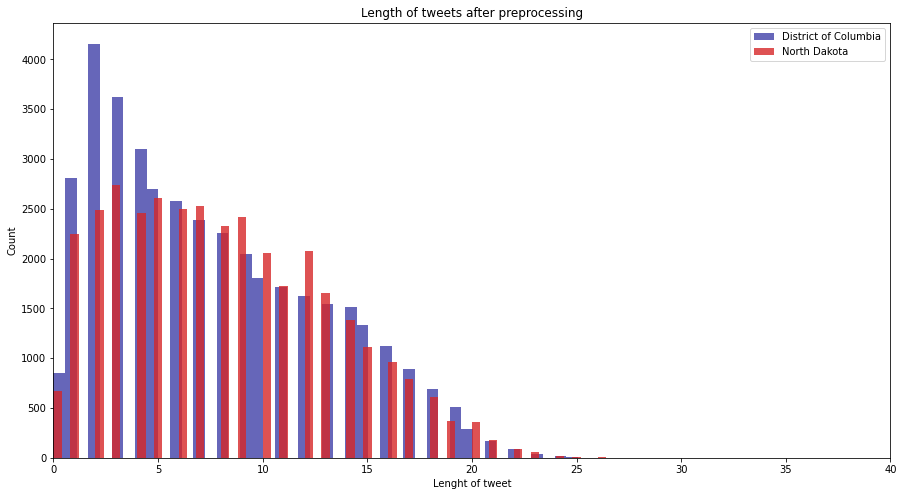

In [22]:
df['length_after'] = df['normalized'].apply(lambda x: len(x.split()))

plt.figure(figsize = (15,8))
plt.title("Length of tweets after preprocessing")
bins = 70
plt.hist(df[df['State'] == 'DC']['length_after'], alpha = 0.6, bins=bins, label='District of Columbia', color = 'darkblue')
plt.hist(df[df['State'] == 'ND']['length_after'], alpha = 0.8, bins=bins, label='North Dakota', color = 'tab:red') 
plt.xlabel('Lenght of tweet')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.xlim(0,40)
plt.show()

In [23]:
df['length_tweet_after'] = df['normalized'].apply(lambda x: len(x))
print("AFTER PRE PROCESSING")
for state in states:
    print(" \nAverage number of characters per tweet {}: {} \
    \n Maximum length: {}; \n Minimum length: {} \n ".format(state, round(np.mean(df[df['State'] == state]['length_tweet_after']), 2),
                                                                np.max(df[df['State'] == state]['length_tweet_after']), 
                                                                np.min(df[df['State'] == state]['length_tweet_after'])))

AFTER PRE PROCESSING
 
Average number of characters per tweet DC: 52.89     
 Maximum length: 233; 
 Minimum length: 0 
 
 
Average number of characters per tweet ND: 58.48     
 Maximum length: 202; 
 Minimum length: 0 
 


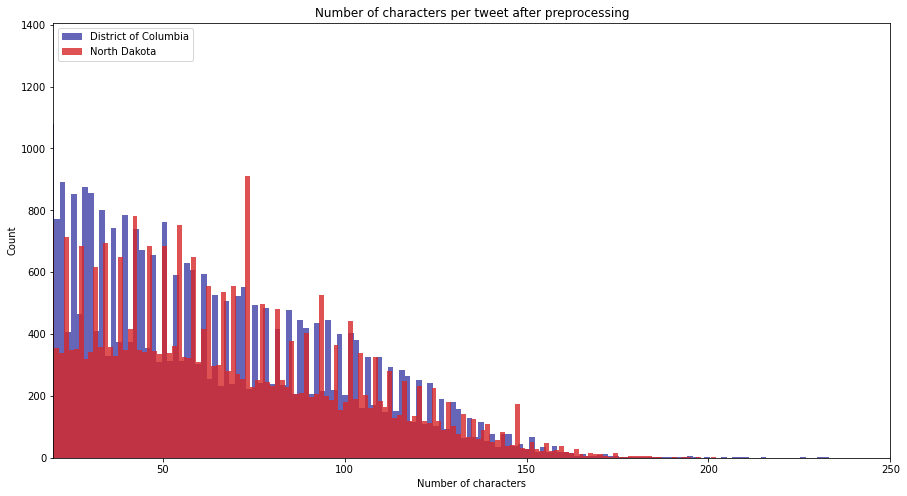

In [24]:
df['length_tweet_after'] = df['normalized'].apply(lambda x: len(x))

plt.figure(figsize = (15,8))
plt.title("Number of characters per tweet after preprocessing")
bins = 150
plt.hist(df[df['State'] == 'DC']['length_tweet_after'], alpha = 0.6, bins=bins, label='District of Columbia', color = 'darkblue')
plt.hist(df[df['State'] == 'ND']['length_tweet_after'], alpha = 0.8, bins=bins, label='North Dakota', color = 'tab:red') 
plt.xlabel('Number of characters')
plt.ylabel('Count')
plt.legend(loc ='upper left')
plt.xlim(20,250)
plt.show()

In [25]:
sum_a_DC = df[df['State']=='DC']['normalized'].str.split().apply(lambda x : sum([len(i) for i in x]))
sum_a_ND = df[df['State']=='ND']['normalized'].str.split().apply(lambda x : sum([len(i) for i in x]))

print('Average word length of tweets after preprocessing: \
    \n {} for District of Columbia; \n {} for North Dakota'.format(round(np.mean(sum_a_DC), 2),
                                                          round(np.mean(sum_a_ND),2)))

Average word length of tweets after preprocessing:     
 45.23 for District of Columbia; 
 50.3 for North Dakota


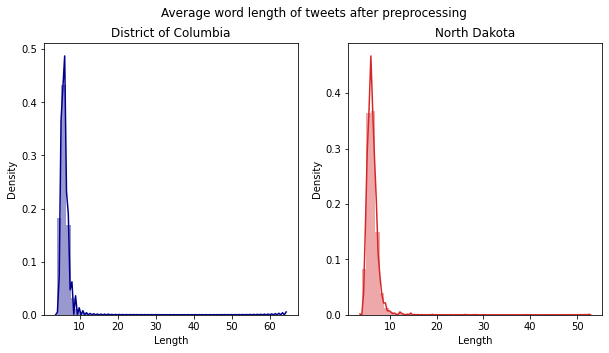

In [26]:
word_len_DC_after = df[df['State']=='DC']['normalized'].str.split().apply(lambda x : [len(i) for i in x])
word_len_ND_after = df[df['State']=='ND']['normalized'].str.split().apply(lambda x : [len(i) for i in x])

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(word_len_DC_after.map(lambda x: np.mean(x)), ax = ax1, color='darkblue')
ax1.set_title('District of Columbia')
ax1.set_xlabel('Length')
ax1.set_ylabel('Density')

sns.distplot(word_len_ND_after.map(lambda x: np.mean(x)),ax=ax2, color = 'tab:red')
ax2.set_title('North Dakota')
ax2.set_xlabel('Length')
ax2.set_ylabel('Density')

plt.suptitle('Average word length of tweets after preprocessing')
plt.show()

### Most common words

Here, I want to look at which are the most common unigrams for the two states.

In [27]:
DC_cleaned = df[df['State'] == 'DC']
ND_cleaned = df[df['State'] == 'ND']

In [28]:
# MOST COMMON WORDS - WITHOUT HASHTAGS

top_10 = {}

count_DC = Counter(" ".join(DC_cleaned.normalized).split())
f_DC = pd.DataFrame(count_DC.most_common(20))
f_DC.columns = ['word', 'frequency']
top_10['DC'] = count_DC.most_common(10)

count_ND = Counter(" ".join(ND_cleaned.normalized).split())
f_ND = pd.DataFrame(count_ND.most_common(20))
f_ND.columns = ['word', 'frequency']
top_10['ND'] = count_ND.most_common(10)

top_10

{'DC': [('people', 7823),
  ('black', 6404),
  ('protest', 5034),
  ('life', 3436),
  ('white', 2888),
  ('matter', 2847),
  ('police', 2469),
  ('make', 2434),
  ('need', 2315),
  ('stand', 2278)],
 'ND': [('black', 6013),
  ('people', 3810),
  ('white', 2722),
  ('woman', 2564),
  ('life', 2533),
  ('police', 2377),
  ('matter', 2242),
  ('racism', 1751),
  ('racist', 1721),
  ('need', 1566)]}

[]

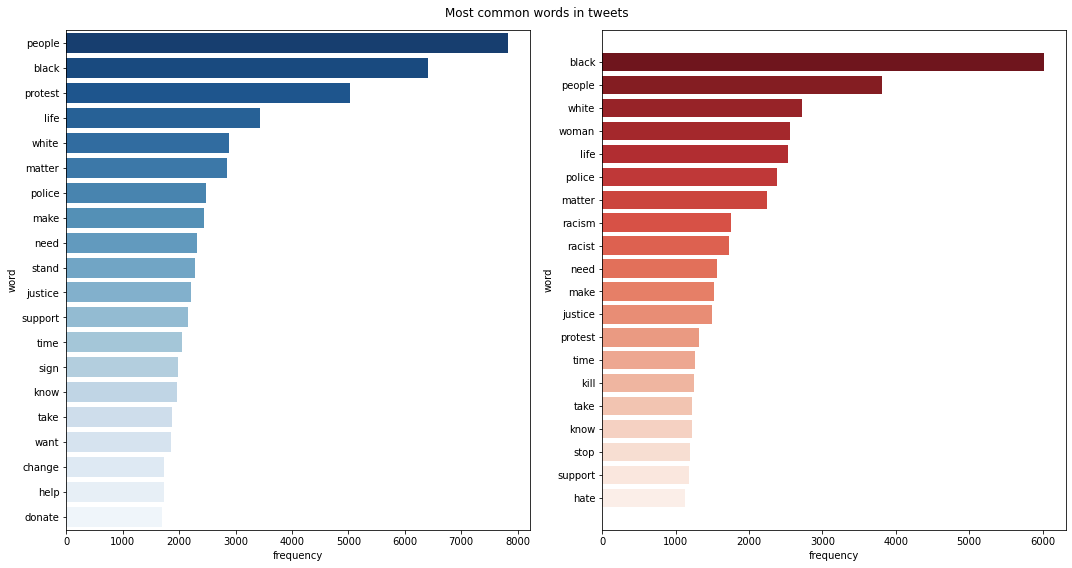

In [29]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,8))
fig.suptitle("Most common words in tweets")
axs = (ax0, ax1)

#ax0.set_tile('DC')
sns.barplot(y = "word", x = "frequency", data = f_DC, ax = ax0, palette = "Blues_r");
#ax1.set_tile('ND')
sns.barplot(y = "word", x = "frequency", data = f_ND, ax = ax1, palette = "Reds_r");

plt.tight_layout()
plt.plot()

It is interesting to notice that Democrats use the words **protest**, **stand**, **donate** more than Republicans, while the reds tweet more about **police**, **kill**, **hate** with respect to the blues. This simple analysis already provides some insights about different ideas, one more *people-oriented* and *inclusion-oriented* (Democrats), while the Republicans seem to be more *violent*. These results are in line with the political ideas of the two parties.

In [30]:
top_10_hash = {}

count_DC_hash = Counter(h for htags in DC_cleaned.hashtags for h in set(htags))
f_DC_hash = pd.DataFrame(count_DC_hash.most_common(20))
f_DC_hash.columns = ['word', 'frequency']
top_10_hash['DC'] = count_DC_hash.most_common(10)

count_ND_hash = Counter(h for htags in ND_cleaned.hashtags for h in set(htags))
f_ND_hash = pd.DataFrame(count_ND_hash.most_common(20))
f_ND_hash.columns = ['word', 'frequency']
top_10_hash['ND'] = count_ND_hash.most_common(10)

top_10_hash

{'DC': [('#georgefloyd', 2570),
  ('#justiceforgeorgefloyd', 2391),
  ('#black_lives_matter', 1628),
  ('#justiceforgeorgeflyod', 1249),
  ('#protests', 997),
  ('#riots2020', 867),
  ('#raisethedegree', 862),
  ('#nojusticenopeace', 656),
  ('#justiceforgeorge', 609),
  ('#icantbreathe', 591)],
 'ND': [('#oprahmeghanharry', 2635),
  ('#mlk', 2591),
  ('#bidenharris', 2581),
  ('#grenfelltower', 2557),
  ('#holocaustmemorialday', 2545),
  ('#stopasianhate', 2478),
  ('#asianlivesmatter', 1776),
  ('#georgefloyd', 1510),
  ('#breonnataylor', 1389),
  ('#racism', 1084)]}

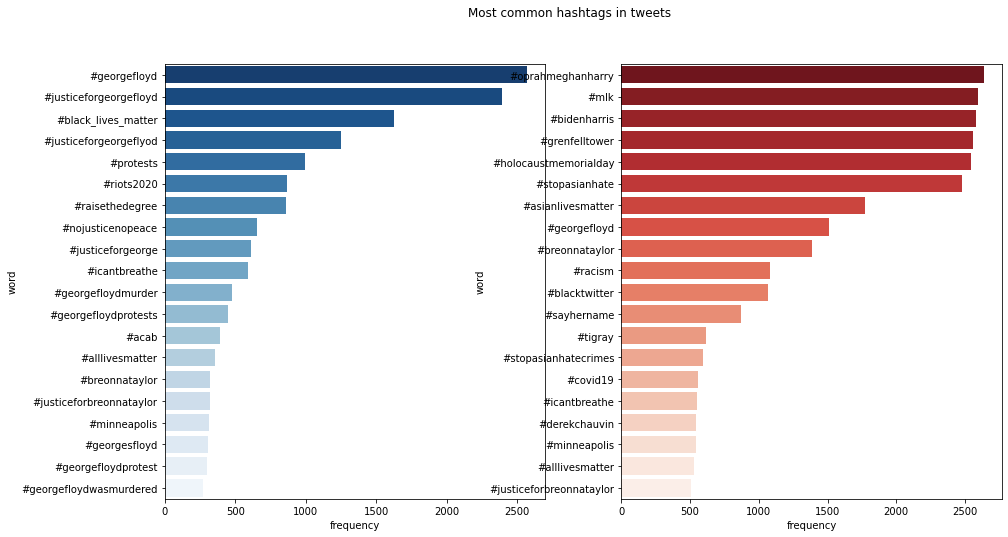

<Figure size 432x288 with 0 Axes>

In [31]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,8))
fig.suptitle("Most common hashtags in tweets")
axs = (ax0, ax1)

plt.figure(figsize = (6, 4))
#ax0.set_tile('DC')
sns.barplot(y = "word", x = "frequency", data = f_DC_hash, ax = ax0, palette = "Blues_r");
#ax1.set_tile('ND')
sns.barplot(y = "word", x = "frequency", data = f_ND_hash, ax = ax1, palette = "Reds_r");

plt.tight_layout()
plt.show()

Hashtags from Democrats show, again, an "interest" around protests; moreover we can see that many of them are about Geoge Floyd, which is in line with the time stamp considered for selecting the tweets.

However, it is difficult to interpret hashtags without considering the whole text of the tweet, since they could have been used both with a positive or negative sense.

## Collocations

In [32]:
# Find the most common collocations in the whole set of tweets

BigColl = BigramCollocationFinder.from_words(" ".join(list(df['normalized'])).split())
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {'_'.join(bigram): pmi for bigram, pmi in BigColl.score_ngrams(score)}
top100_collocations = np.array(Counter(collocations).most_common(100))

top100_collocations[:10,0]

array(['george_floyd', 'breonna_taylor', 'life_matter', 'sign_petition',
       'dirt_insert', 'nail_dirt', 'sharp_nail', 'rape_sharp',
       'black_life', 'derek_chauvin'], dtype='<U49')

In [33]:
# 20 MOST COMMON COLLOCATIONS FOR THE TWO COUNTRIES

#DC
BigColl_DC = BigramCollocationFinder.from_words(" ".join(DC_cleaned.normalized).split()) 
bgm_DC = BigramAssocMeasures()
score_DC = bgm_DC.mi_like
collocationsDC = {' '.join(bigram): pmi for bigram, pmi in BigColl_DC.score_ngrams(score)}
top20_DC = Counter(collocationsDC).most_common(20) 
Big_DC = pd.DataFrame(top20_DC)
Big_DC.columns = ['bigram', 'score']

#ND
BigColl_ND = BigramCollocationFinder.from_words(" ".join(ND_cleaned.normalized).split()) 
bgm_ND = BigramAssocMeasures()
score_ND = bgm_ND.mi_like
collocationsND = {' '.join(bigram): pmi for bigram, pmi in BigColl_ND.score_ngrams(score)}
top20_ND = Counter(collocationsND).most_common(20)  
Big_ND = pd.DataFrame(top20_ND)
Big_ND.columns = ['bigram', 'score']

Big_DC

,bigram,score
0,george floyd,803.487189
1,sign petition,507.533301
2,life matter,382.889754
3,stay safe,234.440016
4,jacob frey,171.067541
5,brother sister,159.319043
6,retweet reply,158.940621
7,black life,141.434086
8,mayor jacob,100.893067
9,social medium,92.442376


In [34]:
Big_ND

,bigram,score
0,breonna taylor,582.878140
1,dirt insert,392.264463
2,nail dirt,381.083528
3,sharp nail,381.083528
4,rape sharp,322.160975
5,george floyd,287.095969
6,life matter,273.435489
7,suffer rape,258.832186
8,girl suffer,194.124139
9,derek chauvin,161.203853


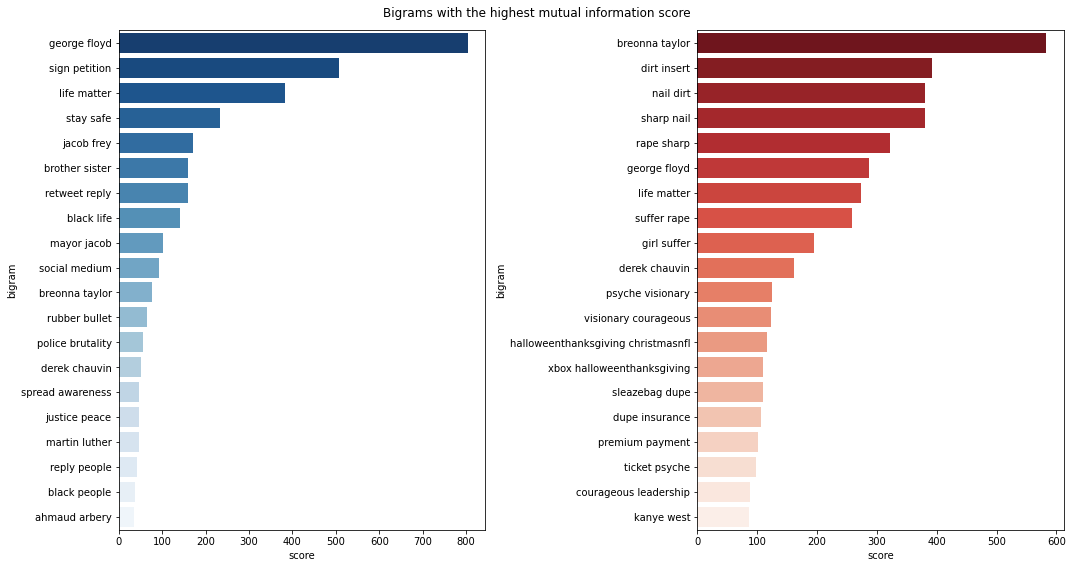

In [35]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (15,8))
fig.suptitle("Bigrams with the highest mutual information score")
axs = (ax0, ax1)

#ax0.set_tile('DC')
sns.barplot(y = "bigram", x = "score", data = Big_DC, ax = ax0, palette = "Blues_r");
#ax1.set_tile('ND')
sns.barplot(y = "bigram", x = "score", data = Big_ND, ax = ax1, palette = "Reds_r");

plt.tight_layout()
plt.show()

In [36]:
# Substitute collocations in the pre-processed text

def match_collocations(tweet):
    text = tweet.split()
    
    BigColl = BigramCollocationFinder.from_words(tweet.split())
    bgm = BigramAssocMeasures()
    score = bgm.mi_like
    coll_score = BigColl.score_ngrams(score)
    
    if coll_score == []: # If there are no collocations in the text
        return tweet                      # just return the text
    else:
        for b in np.array(coll_score)[:, 0]: #otherwise, look at the collocations

            if "_".join(b) in top100_collocations:    # if the bigram is in the 100 most common collocations,
                for i in range(len(text)-1):             
                    if (text[i] == b[0]) & (text[i+1] == b[1]): 
                        text[i] = "_".join(b)              # merge the words with _
                        text.pop(i + 1)                    # and remove the "old" bigram from the text
                        break
    
    return " ".join(text)

df['normalized'] = df['normalized'].apply(match_collocations)

In [37]:
# Have a look at the result:
df['normalized'][89]

'annoying people george_floyd movement clout know talk twitter know'

In [38]:
#Most common bigrams

DC_cleaned = df[df['State'] == 'DC']
NC_cleaned = df[df['State'] == 'ND']

top_10_bi = {}
for c, i in enumerate([DC_cleaned, ND_cleaned]):
    bigram_counts = Counter(ngrams(" ".join(i).split(), 2))
    top_10_bi[c] = bigram_counts.most_common(10)
top_10_bi

{0: [(('id', 'username'), 1),
  (('username', 'text'), 1),
  (('text', 'date'), 1),
  (('date', 'State'), 1),
  (('State', 'length_before'), 1),
  (('length_before', 'length_tweet_before'), 1),
  (('length_tweet_before', 'hashtags'), 1),
  (('hashtags', 'normalized'), 1),
  (('normalized', 'length_after'), 1),
  (('length_after', 'length_tweet_after'), 1)],
 1: [(('id', 'username'), 1),
  (('username', 'text'), 1),
  (('text', 'date'), 1),
  (('date', 'State'), 1),
  (('State', 'length_before'), 1),
  (('length_before', 'length_tweet_before'), 1),
  (('length_tweet_before', 'hashtags'), 1),
  (('hashtags', 'normalized'), 1),
  (('normalized', 'length_after'), 1),
  (('length_after', 'length_tweet_after'), 1)]}

# 2. Analysis

### TF-IDF
The following function calculates TF-IDF to evaluate the importance of words in the collection of tweets;
it also displays a plot of the tf-idf over idf scores, where the dimension of the points is determined by the frequency of the term the point represents.

In [39]:
def Vectoriozer(df, state):

    doc = df.normalized.apply(str).tolist() 
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                       stop_words='english', 
                                       analyzer='word', 
                                       min_df=0.001, 
                                       max_df=0.8, 
                                       sublinear_tf=True, 
                                       use_idf=True)
    
    count_vectorizer = CountVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.8)
    
    X = tfidf_vectorizer.fit_transform(doc)
    X_word = count_vectorizer.fit_transform(doc)

    word_counts = X_word.toarray()
    word_tfidf = X.toarray()

    df_tfidf = pd.DataFrame(data = {'word': count_vectorizer.get_feature_names(),
                                    'tf': word_counts.sum(axis = 0),
                                    'idf': tfidf_vectorizer.idf_,
                                    'tfidf': word_tfidf.sum(axis=0)})

    df_tfidf = df_tfidf.sort_values(['tfidf','tf','idf'], ascending = False)
    
    fig, ax = plt.subplots(figsize = (16,12))

    df_tfidf['tf'] /= 5
    blues = plt.get_cmap('Blues') 
    reds = plt.get_cmap('Reds')

    if state == 'DC':
        blues = plt.get_cmap('Blues') 
        color = [blues(1 - float(i)/(len(df_tfidf)-1)) 
                 for i in range(len(df_tfidf))]
    elif state == 'ND':
        blues = plt.get_cmap('Reds') 
        color = [blues(1 - float(i)/(len(df_tfidf)-1)) 
                 for i in range(len(df_tfidf))]

    
    plt.scatter(x = df_tfidf['tfidf'],
                    y = df_tfidf['idf'],
                    s = df_tfidf['tf'],
                    c = color)
    plt.xlabel('tf-idf')
    plt.ylabel('idf')
                            
    w = []
    
    for label, x, y in zip(df_tfidf.iloc[:10,0], df_tfidf.iloc[:10,3], df_tfidf.iloc[:10,2]):
            txt = plt.annotate(label, xy = (x, y), xytext=(x,y+0.2))
            w.append(label)
    plt.title('Scatter plot of TFIDF and IDF values, scaled by TF, for words in {} tweers'.format(state))
    print('The 10 words with the highest TF-IDF score are:{}'.format(w))
    
    return X, df_tfidf 

DEMOCRATS
The 10 words with the highest TF-IDF score are:['people', 'protest', 'black', 'stand', 'need', 'white', 'support', 'make', 'matter', 'help']

REPUBLICANS
The 10 words with the highest TF-IDF score are:['black', 'people', 'white', 'life', 'police', 'matter', 'racist', 'racism', 'woman', 'justice']


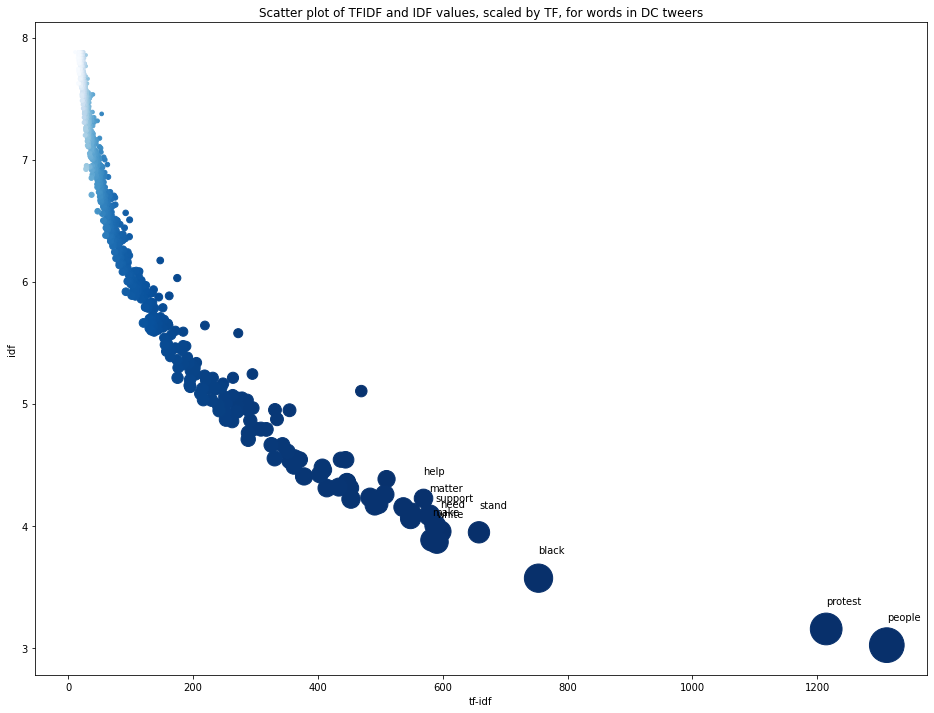

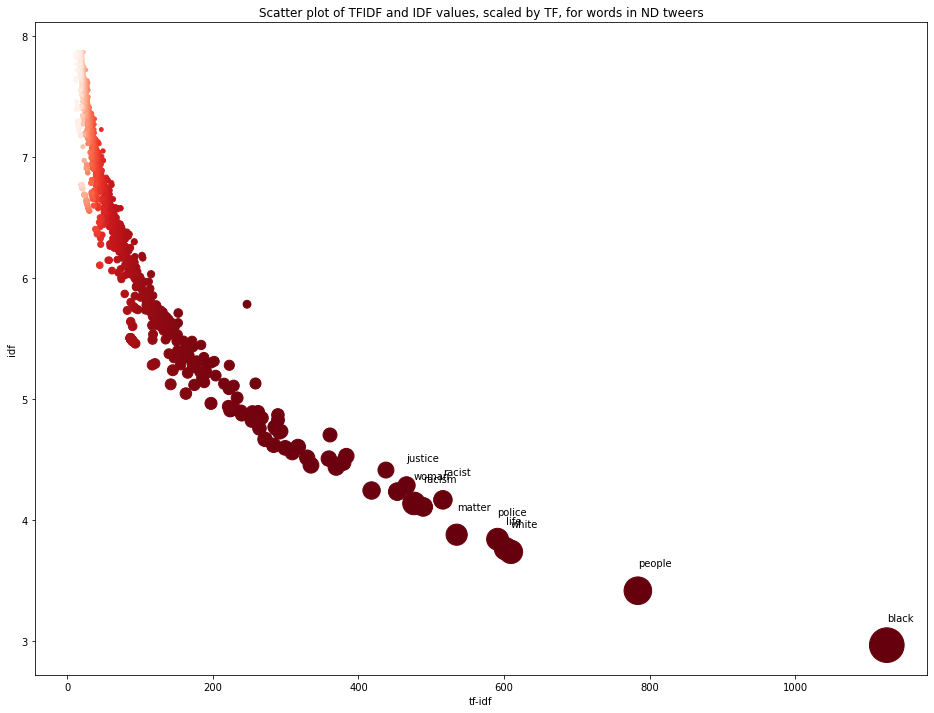

In [40]:
print('DEMOCRATS')
X_DC, df_tfidf_DC = Vectoriozer(DC_cleaned, 'DC')
print('\nREPUBLICANS')
X_ND, df_tfidf_ND = Vectoriozer(ND_cleaned, 'ND')

In [41]:
# Plot the word with highest TF-IDF for DC vs ND
df_tfidf_ND[:10]

,word,tf,idf,tfidf
119,black,1202.6,2.966627,1125.650365
899,people,762.0,3.416205,783.752960
1406,white,544.4,3.737237,609.420159
727,life,506.6,3.763001,602.039866
930,police,475.4,3.841703,591.020588
773,matter,448.4,3.879100,534.857740
1031,racist,344.2,4.166945,515.954667
1030,racism,350.2,4.108737,488.897698
1424,woman,512.8,4.137417,476.296529
674,justice,298.6,4.286521,466.009720


In [42]:
df_tfidf_DC[:10]

,word,tf,idf,tfidf
705,people,1204.4,3.022158,1311.537655
790,protest,1006.8,3.154743,1214.443954
84,black,801.0,3.570855,753.534824
983,stand,455.6,3.946621,658.098371
647,need,463.0,3.953323,596.139986
1134,white,517.0,3.867313,590.699090
1022,support,430.4,4.002546,588.017475
577,make,486.8,3.883306,582.517952
592,matter,431.6,4.086168,578.860902
434,help,345.4,4.224177,569.290426


In [43]:
freq_combined = pd.merge(df_tfidf_DC, df_tfidf_ND, on = 'word', how = 'inner', suffixes=('_DC', '_ND'))
freq_combined.head(20)

,word,tf_DC,idf_DC,tfidf_DC,tf_ND,idf_ND,tfidf_ND
0,people,1204.4,3.022158,1311.537655,762.0,3.416205,783.752960
1,protest,1006.8,3.154743,1214.443954,262.6,4.436763,369.392918
2,black,801.0,3.570855,753.534824,1202.6,2.966627,1125.650365
3,stand,455.6,3.946621,658.098371,161.6,4.893881,262.242799
4,need,463.0,3.953323,596.139986,313.2,4.235007,453.331634
5,white,517.0,3.867313,590.699090,544.4,3.737237,609.420159
6,support,430.4,4.002546,588.017475,236.6,4.528751,383.338663
7,make,486.8,3.883306,582.517952,303.4,4.244114,417.990479
8,matter,431.6,4.086168,578.860902,448.4,3.879100,534.857740
9,help,345.4,4.224177,569.290426,170.0,4.819869,253.290906


Again, we can see that "people" and "protest" have a higher TF-IDF score in tweets from DC, which may highlight the democrats’ use of twitter to send concrete messages with respect to some important constitutional rights.

"Racism" has, instead, a higher TF-IDF score in Republican tweets, which is in line with the observations I was making at the beginning of the notebook.

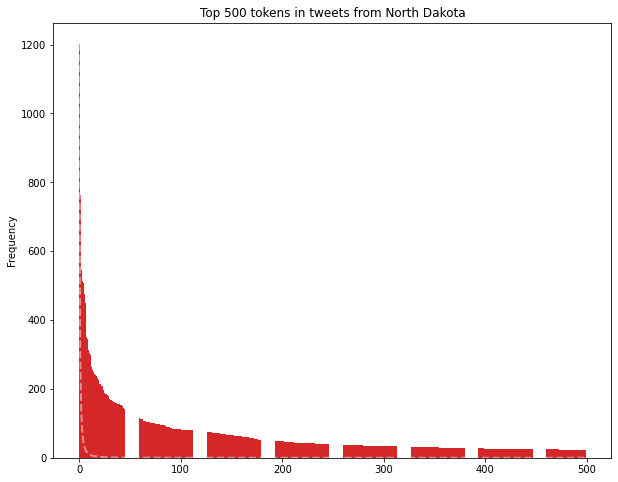

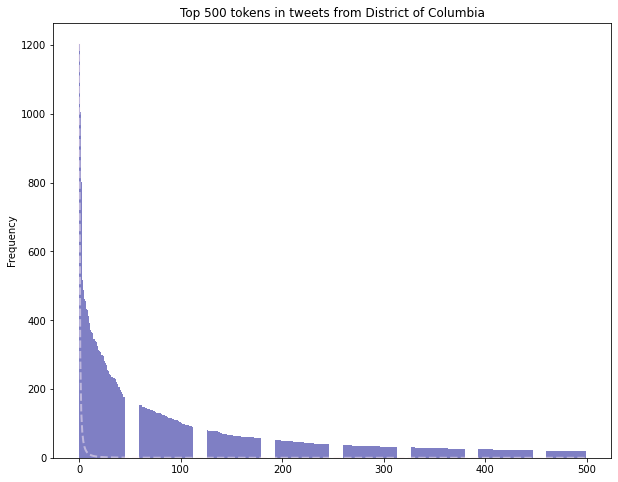

In [44]:
#ZIPF DISTRIBUTIONS OF THE WORDS USING RESULTS FROM TF-IDF

#North Dakota 

plt.figure(figsize=(10,8))
x = np.arange(500)
s = 2
expected_zipf = [df_tfidf_ND.sort_values(by = 'tf', ascending = False)['tf'].iloc[0]/(i+1)**s for i in x]
plt.bar(x, df_tfidf_ND.sort_values(by = 'tf', ascending = False)['tf'].iloc[:500], align='center', color = 'tab:red')
plt.plot(x, expected_zipf, color='lavenderblush', linestyle='--', linewidth=2, alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets from North Dakota')

#District of Columbia 

plt.figure(figsize=(10,8))
expected_zipf = [df_tfidf_DC.sort_values(by='tf', ascending=False)['tf'].iloc[0]/(i+1)**s for i in x]
plt.bar(x, df_tfidf_DC.sort_values(by='tf', ascending=False)['tf'].iloc[:500], align='center', alpha=0.5, color = 'darkblue')
plt.plot(x, expected_zipf, color='lavenderblush', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets from District of Columbia')
plt.show()

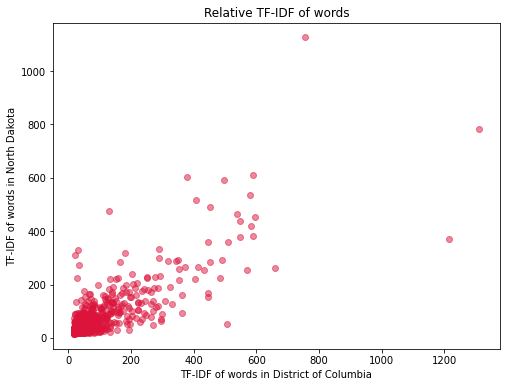

In [45]:
#What if we plot the frequency in DC of a word on X-axis, 
#and the  frequency in ND on Y-axis?

#sum_tf_DC = freq_combined.tf_DC.sum()
#sum_tf_ND = freq_combined.tf_ND.sum()
#freq_combined['relative_DC'] = freq_combined.tf_DC / freq_combined.tf_DC.sum()
#freq_combined['relative_ND'] = freq_combined.tf_ND / freq_combined.tf_ND.sum()

plt.figure(figsize=(8,6))
ax = sns.regplot(x = 'tfidf_DC', y="tfidf_ND",
                 fit_reg=False, scatter_kws={'alpha':0.5},
                 data = freq_combined, color = 'crimson')
plt.ylabel('TF-IDF of words in North Dakota')
plt.xlabel('TF-IDF of words in District of Columbia')
plt.title('Relative TF-IDF of words')
plt.show()

### Application of dimensionality reduction techniques to TF-IDF output:

I decided to use TruncatedSVD because, in contrast with PCA, it allows to reduce dimensionality of sparce matrices. Moreover, it performs dimensionality reduction much faster than t-SNE when the number of features is very high since it suppress some noise and speeds up the computation of pairwise distances between samples.
(Reference : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html )
The purpose of the application of dimensionality reduction to TF-IDF output is to prepare the input for clustering.
By clustering the tweets I want to see wether there are some remarkable patterns in the data.

In [46]:
from sklearn.decomposition import TruncatedSVD

doc = df.normalized.apply(str).tolist() 

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),    #as defined in the Vectorizer function above
                                       stop_words='english', 
                                       analyzer='word', 
                                       min_df=0.001, 
                                       max_df=0.8, 
                                       sublinear_tf=True, 
                                       use_idf=True)

X = tfidf_vectorizer.fit_transform(doc)

svd = TruncatedSVD(n_components = 2)
U = svd.fit_transform(X)

print(U.shape)

(76342, 2)


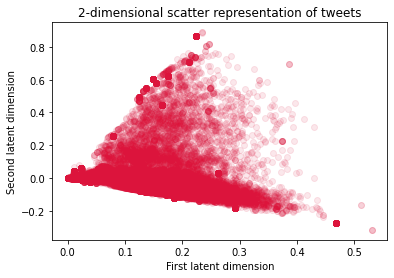

In [47]:
plt.title('2-dimensional scatter representation of tweets')
plt.scatter(U[:, 0], U[:, 1], color = 'crimson', alpha = 0.1)
plt.xlabel('First latent dimension')
plt.ylabel('Second latent dimension')
plt.show()
#assign colors depending on the state

### Word embedding: Word2Vec

**For visualization:**
I chose to apply t-distributed Stochastic Neighbor Embedding (t-SNE) since it allows to maintain the relative relationships between the vectors.

I performed dimensionality reduction on the output of Word2Vec to have a graphical visualization of which are the most similar words to "black", "protest", "life" and "racism", which are among the most common words for both states.

In [48]:
docs = df.normalized.tolist()
corpus = [tweet.split() for tweet in docs] # preparing the input for Word2Vec

# Initialization of the model
w2v_model = Word2Vec(size=300, # vector size: I opted for 300 since
                     # according to research, the quality for vector representations improves 
                     # as you increase the vector size until you reach 300 dimensions.
                     window = 3, # I want to keep the window small to capture syntactic similarities 
                     iter = 100, 
                     min_count = 2, 
                     workers = -1)

# build the vocabulary
w2v_model.build_vocab(corpus)

# train the model
w2v_model.train(corpus, 
                total_examples=w2v_model.corpus_count, 
                epochs=w2v_model.epochs)

(0, 0)

In [49]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from sklearn.manifold import TSNE


def similar_words(start_words, w2v_model):
    vectors = []
    labels = []
    
    for word in start_words:
        vec = []
        words = []
        
        for similar, score in w2v_model.most_similar(word, topn=10):
            words.append(similar)
            vec.append(w2v_model[similar])
        vectors.append(vec)
        labels.append(words)
        
    vectors = np.array(vectors)
    a, b, c = vectors.shape
    vectors = vectors.reshape(a * b, c)
    tsne = TSNE(perplexity= 15, n_components=2)
    embeddings = tsne.fit_transform(vectors)
    embeddings = np.array(embeddings).reshape(a, b, 2)
    
    return embeddings, labels



def tsne_plot_similar_words(start_words, w2v_model):
    
    embeddings, labels = similar_words(start_words, w2v_model)
    
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    
    for label, emb, words, color in zip(start_words, embeddings, labels, colors):
        #print(color)
        x = emb[:, 0]
        y = emb[:, 1]
        plt.scatter(x, y, c=color, s = 70, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title("Most similar words to {}".format(start_words))
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

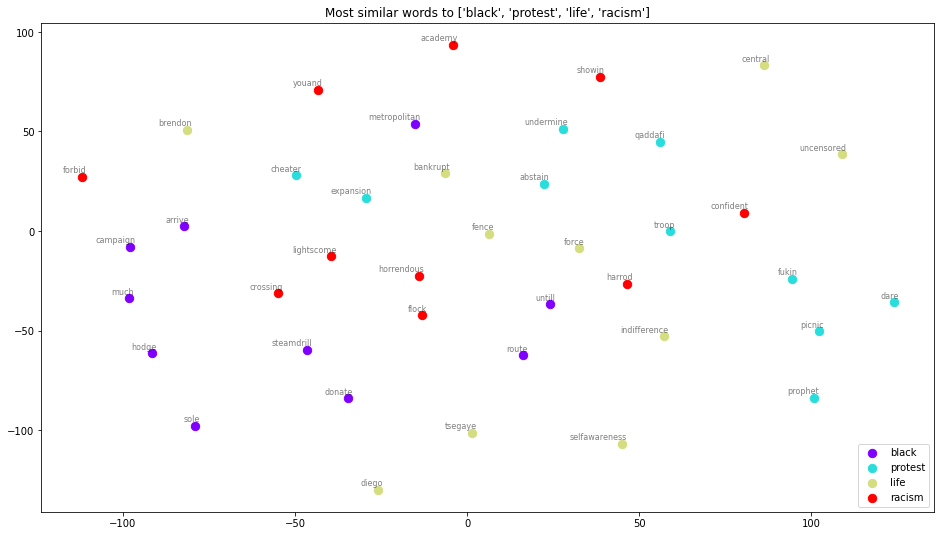

In [50]:
tsne_plot_similar_words(["black", "protest", "life", "racism"], w2v_model)

Next, I built two different Word2Vec models for the two states and created a graphical visualization of which are the most similar words to "black", "protest", "life" and "racism" in tweets written by Democrats and Republicans.

In [51]:
docsDC = df[df['State'] =='DC'].normalized.tolist()
docsND = df[df['State'] =='ND'].normalized.tolist()

corpusDC = [tweet.split() for tweet in docsDC]
corpusND = [tweet.split() for tweet in docsND]

In [52]:
#WORD2VEC MODEL FOR DC
w2v_DC = Word2Vec(size=300, 
                     window=3, 
                     sample=0.001, 
                     iter=100, 
                     negative=5, 
                     min_count=2, 
                     workers=-1)
                  
                  
w2v_DC.build_vocab(corpusDC)
w2v_DC.train(corpusDC, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

                 
#WORD2VEC MODEL FOR ND
w2v_ND = Word2Vec(size=300, # vector size: I opted for 300 since
                     # according to research, the quality for vector representations improves 
                     # as you increase the vector size until you reach 300 dimensions.
                     window=3, # I want to keep the window small to capture syntactic similarities
                     sample=0.001, 
                     iter=100, 
                     negative=5, 
                     min_count=2, 
                     workers=-1, 
                     hs=0)
                  
                  
w2v_ND.build_vocab(corpusND)
w2v_ND.train(corpusND, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(0, 0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

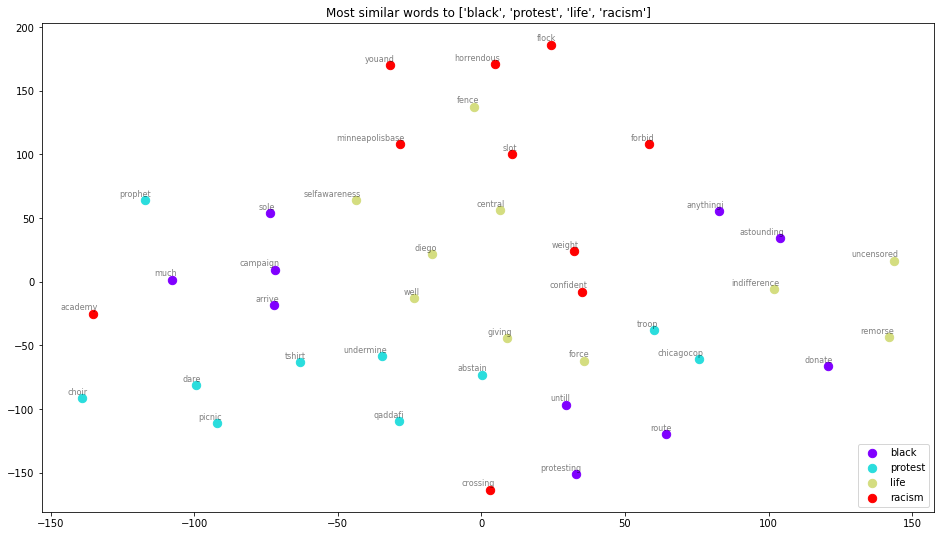

In [53]:
#Most similar words to "black", "protest", "life", "racism" for DC's tweets
tsne_plot_similar_words(["black", "protest", "life", "racism"], w2v_DC)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

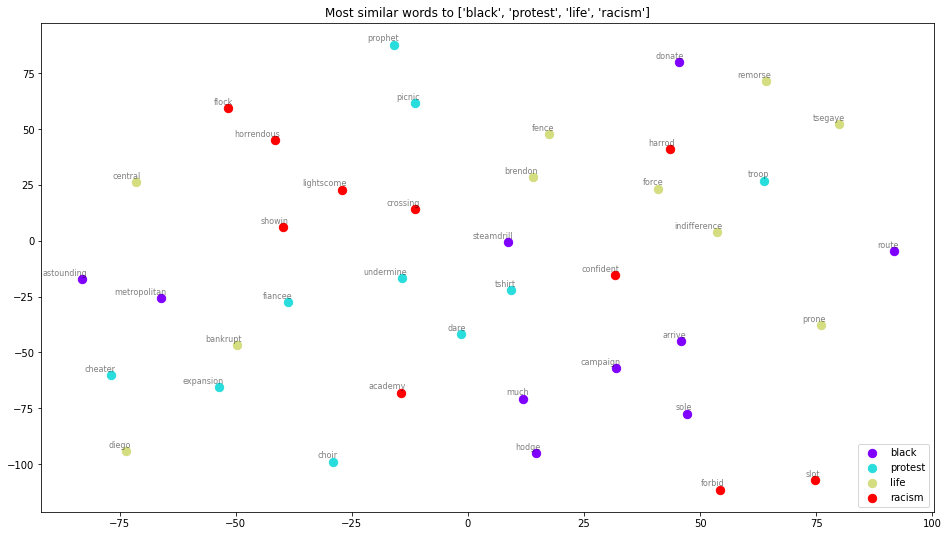

In [54]:
#Most similar words to "black", "protest", "life", "racism" for ND's tweets
tsne_plot_similar_words(["black", "protest", "life", "racism"], w2v_ND)

In [55]:
print('PROTEST: MOST SIMILAR WORDS \n Democrats: {} \n Republicans: {}'.format(
                                                        w2v_DC.most_similar(positive = 'protest'),
                                                        w2v_ND.most_similar(positive = 'protest')))

PROTEST: MOST SIMILAR WORDS 
 Democrats: [('picnic', 0.21950864791870117), ('undermine', 0.20442208647727966), ('dare', 0.20198678970336914), ('troop', 0.19870346784591675), ('prophet', 0.1938668191432953), ('qaddafi', 0.19046998023986816), ('abstain', 0.1888856291770935), ('tshirt', 0.18647223711013794), ('choir', 0.18610477447509766), ('chicagocop', 0.1835184097290039)] 
 Republicans: [('picnic', 0.21950864791870117), ('expansion', 0.20724307000637054), ('undermine', 0.20442208647727966), ('dare', 0.20198678970336914), ('troop', 0.19870346784591675), ('cheater', 0.19656528532505035), ('prophet', 0.1938668191432953), ('tshirt', 0.18647223711013794), ('choir', 0.18610477447509766), ('fiancee', 0.17733116447925568)]


### Author Topic Model

I decided to perform Author Topic Model to check wether there are topics "hidden" in the tweets and, if this is the case, to see whether there are clear differences among tweets from peole of different political parties.

In [56]:
instances = df['normalized'].apply(str.split).tolist()

phrases = Phrases(instances, min_count=5, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)
dictionary.filter_extremes(no_below=50, no_above=0.3)

In [57]:
corpus_atm = [dictionary.doc2bow(text) for text in instances]
tfidfmodel = TfidfModel(corpus_atm)
model_corpus = tfidfmodel[corpus_atm]

In [58]:
author2doc = defaultdict(list)

for i, state in enumerate(df['State']):
    author2doc[state].append(i)

In [59]:
'''
tuning of the optimal number of topic takes some time to run!
'''

coherence_values = []
author_model_list = []

dev_size = 15000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(5, 12):
    author_model = AuthorTopicModel(corpus = list(corpus_atm[:dev_size]), 
                                    author2doc=dev_author2doc, # the only difference to LDA 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=42)
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, np.round(umass_score,2), np.round(cv_score,2))
    coherence_values.append((num_topics, umass_score, cv_score))

5 -3.59 0.29
6 -3.65 0.3
7 -3.71 0.3
8 -3.71 0.3
9 -4.21 0.3
10 -4.36 0.31
11 -4.41 0.3


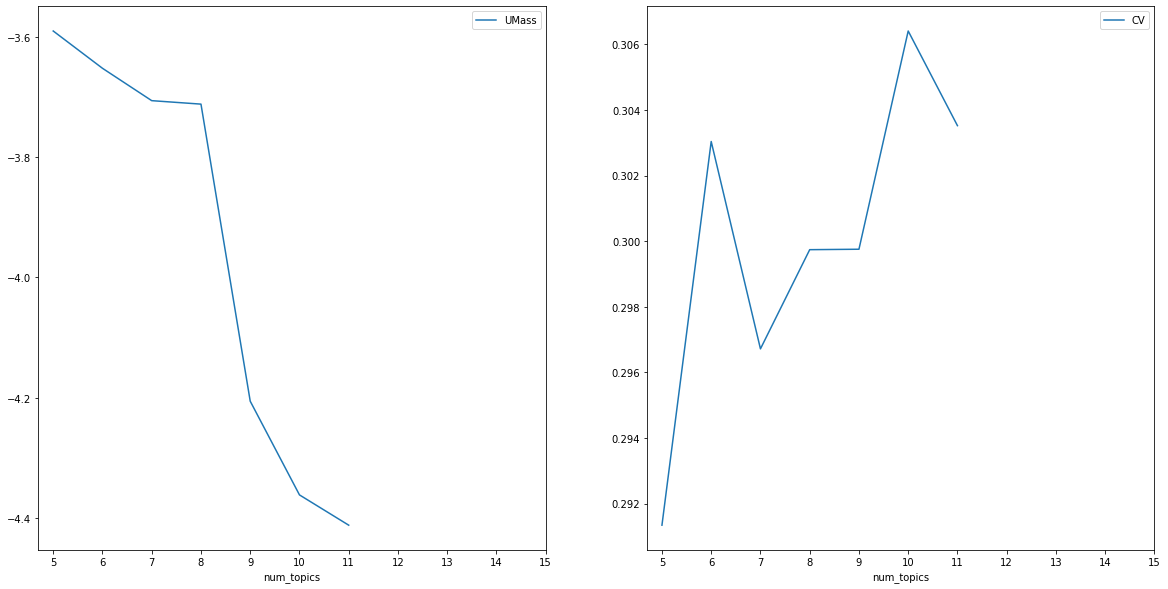

In [60]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(5,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(5,16));

After having calculated both Umass and CV coherence scores for different number of topics, the final choice of the "optimal" number of topic was 6 since it leads to good scores on both models.

One reason for which coherence scores are not very high might be because all the tweets are about the same "major" topic, i.e. *black lives matter*.

In [61]:
n_topics_author = 6 # "optimal" number of topic selected
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200

author_model = AuthorTopicModel(corpus=list(corpus_atm), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=42)

In [62]:
topic_sep = re.compile("0\.[0-9]{3}\*") 

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "america", "find", "biden", "struggle", "need"
2 "forget", "work", "trial", "force", "history"
3 "support", "need", "help", "make", "keep"
4 "black", "woman", "year", "vote", "save"
5 "people", "protest", "take", "know", "police"
6 "matter", "racism", "racist", "justice", "forget"


In [63]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }

for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

target_states = 'DC ND'.split()
for state in target_states:
    print(state, author_vecs[state])        

DC {'america, find': 0.01689404327763221, 'forget, work': 0.10130194711847677, 'support, need': 0.10939386047862446, 'black, woman': 0.015439371158973852, 'people, protest': 0.33838134295167765, 'matter, racism': 0.41858943501461504}
ND {'america, find': 0.20049048923995935, 'forget, work': 0.1083859823396943, 'support, need': 0.14844638949089725, 'black, woman': 0.2273344315425161, 'people, protest': 0.12596357431604, 'matter, racism': 0.18937913307089294}


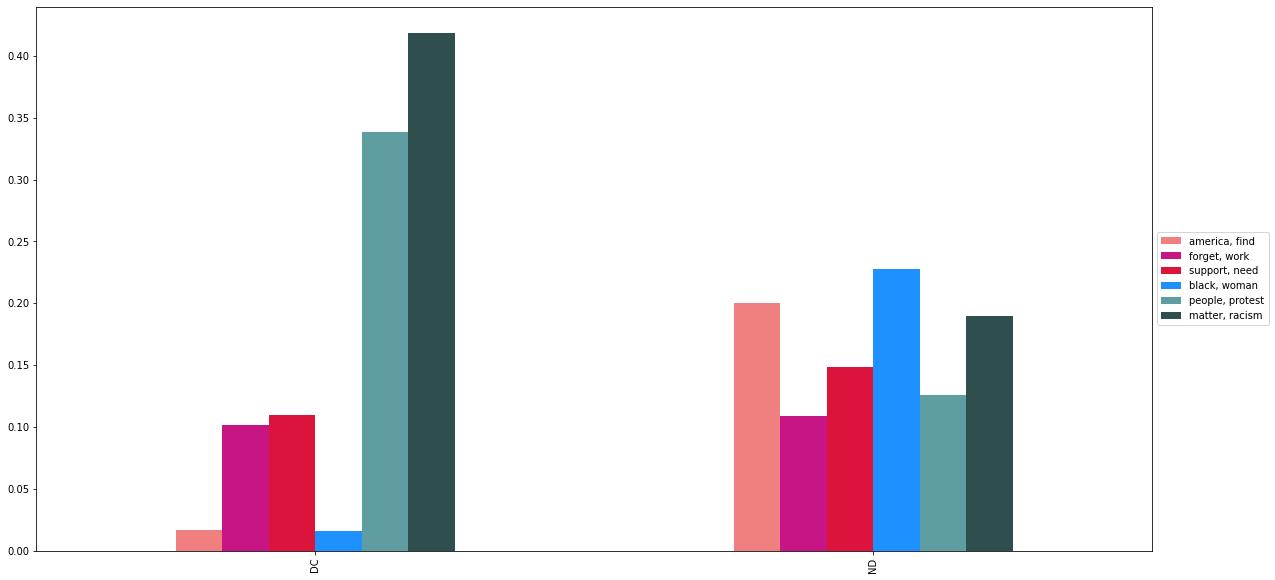

In [64]:
color_list = ["lightcoral", "mediumvioletred", "crimson", "dodgerblue", "cadetblue", "darkslategray"]
author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_states].T.plot.bar(ax=ax, color = color_list)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

From the plots it can be notices that Democrats's main topics are topic #5 and #6, which seem focused on the enforcement of rights.


On the other hand, Republicans talk more about topics #1 and #4, which seem to be connected to Trump's motto *"Make America great again!*


### Clustering

Since I have assessed that the tweets can be divided into 6 different topics, in the following code I tried to cluster the tweets into 6 clusters so that to see wether tweets are clearly separated or not.

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('vlag') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

In [66]:
from sklearn.cluster import KMeans, AgglomerativeClustering
tfidf_vectorizer
k = 6

X = tfidf_vectorizer.fit_transform(doc)
X2 = TruncatedSVD(n_components=300).fit_transform(X) 

agg = AgglomerativeClustering(n_clusters=k)

In [67]:
sample = np.random.choice(len(X2), replace=False, size=8000)
%time agg_sample_ids = agg.fit_predict(X2[sample])

CPU times: user 20.7 s, sys: 509 ms, total: 21.2 s
Wall time: 22.4 s


In [68]:
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
print(centroids.shape)

(6, 300)


In [69]:
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2)

plot_sample = np.random.choice(len(X2), replace=False, size=200)

CPU times: user 1.04 s, sys: 173 ms, total: 1.21 s
Wall time: 681 ms


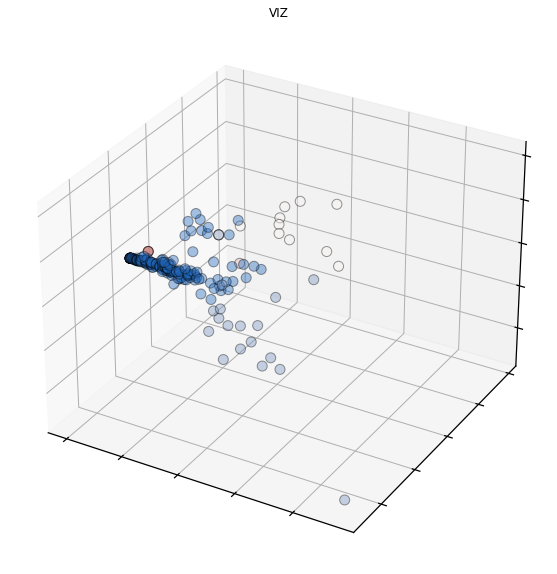

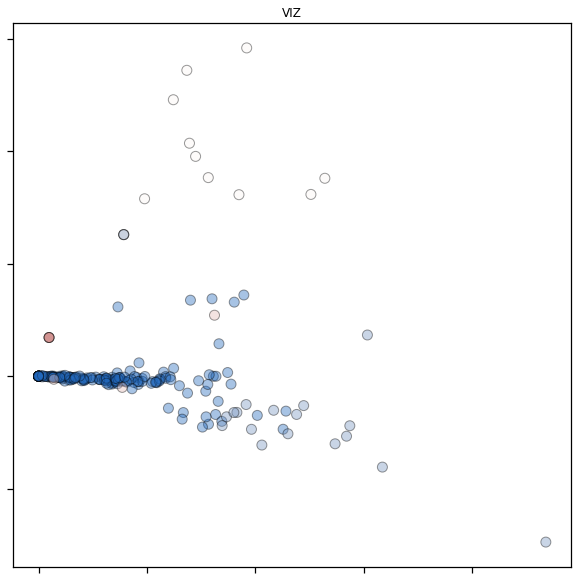

In [70]:
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample])
plot_vectors(X2[plot_sample], labels=km.labels_[plot_sample], dimensions=2)

Clustering does not give any interesting result. This is in line with expectations, since all the tweets revolve around the same topic. 

### Language model
What would be an average tweet generated by a democrat and a republican aroung #BlackLivesMatter?

In [71]:
corpusDC = [DC_cleaned['text'].to_list()[i].split() for i in range(len(DC_cleaned))]
corpusND = [ND_cleaned['text'].to_list()[i].split() for i in range(len(ND_cleaned))]

In [72]:
#DEMOCRATS

smoothing = 0.001
START = '_***_'
STOP = '_STOP_'

def corpus_to_count(corpus):
    counts = defaultdict(lambda: defaultdict(lambda: smoothing))
    for sentence in corpusDC:
        tokens = [START, START] + sentence + [STOP]
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[(u, v)][w] += 1
    return counts
        
        
def generate(corpus, initial=[]):
    result = [START, START] + initial
    for i in range(len(result)-1):
        try:
            next_word = sample_next_word(result[-(i+2)], result[-(i+1)], corpus)
        except ValueError:
            pass
    result.append(next_word)
    while next_word != STOP:
        try:
            next_word = sample_next_word(result[-2], result[-1], corpus)
        except ValueError:
            next_word = sample_next_word(START, result[-1], corpus)
        result.append(next_word)
    return ' '.join(result[2:-1])


def sample_next_word(u, v, corpus):
    keys, values = zip(*corpus_to_count(corpus)[(u, v)].items())
    values = np.array(values)
    values /= values.sum() 
    sample = np.random.multinomial(1, values)
    return keys[np.argmax(sample)]

In [75]:
print(generate(corpus = corpusDC, initial = 'Racism is'.split()))

Racism is This is what makes our human rights shouldn’t have to go down because I haven’t spoken sooner. I’m ashamed to ... seek whatever you can do, u just can't murder a black nor white person. It isn't a all black lives. #BlackLivesMatter https://t.co/LssZ7SthQP


In [76]:
print(generate(corpus = corpusND, initial = 'Racism is'.split()))

Racism is Brown and black lives are more important things right now filled with ever high school with these resources and links as I can to get them. The public execution of George Floyd was killed, so I can tell.. Y’all dumb as hell.. Let’s focus on solutions — we hope it stays that way... ill be right there with her friends. This act took place today but every other major city in standstill in 05’ when they know the real issue. Shame on you to those you love, play video games, take a knee are the real issue here and we need to stick together and support y’all. You are gorgeous. Hold Fast. #BlackLivesMatter (Art by @sacree_frangine on ig basically telling me not to kill #UNARMED Black men &amp; women lost too many lives we can’t do anything from history? #BlackLivesMatter


### Bonus: NER

#### Who are the most named people?

In [53]:
''' 
this takes some time to run!
'''

# From original text:

def NER(document):
    people = []
    for entity in nlp(document).ents:
        if entity.label_ == 'PERSON':
            people.append(entity.text)
    return people

df['entities'] = df['text'].apply(NER)

In [65]:
People = []
for i in df['entities']:
    if i != []:
        for k in range(len(i)):
            People.append(i[k])

In [64]:
count_people = Counter(People)
count_people.most_common(5)

[('OprahMeghanHarry', 2353),
 ('George Floyd', 1186),
 ('Breonna Taylor', 588),
 ('Tigray', 417),
 ('Harry', 260)]